In [5]:
from triangular import LatticeTriangular as LT
from base import Main as base
from String import String
import numpy as np
import random

def print_debug(arg):
    """Print argument if needed.

    You can use this function in any parts and its behavior is toggled here.
    """
    # print arg
    pass


class Main(base):
    """任意に設定したstringの近傍点に点を追加し成長させるモデル

    グラフ上で左端と右端に固定されたstringの近傍点を探索，ランダム(後には曲げ
    弾性による重み付けの効果を追加)に選択し，stringを成長させていくモデル
    """

    def __init__(self, Lx=40, Ly=40, lattice_scale=10.,
                 size=[5, 4, 10, 12], plot=True):
        """Init function of Main class.

        Lx (int (even)): 格子のx方向(グラフではy軸)の格子点数
        Ly (int (even)): 格子のy方向(グラフではx軸)の格子点数
        lattice_scale (int or float): グラフのx，y軸の実際のスケール(関係ない)
        """
        # Create triangular lattice with given parameters
        self.lattice = LT(np.zeros((Lx, Ly), dtype=np.int),
                          scale=lattice_scale, boundary='periodic')

        self.occupied = np.zeros((Lx, Ly), dtype=np.bool)
        self.number_of_lines = sum(size) * Lx

        # Put the strings to the lattice
        self.strings = self.create_random_strings(len(size), size)
        # self.strings = [String(self.lattice, 1, int(Lx / 2), - int(Lx / 4) % Ly,
        #                        vec=[0] * ((Ly - 1) / 2) + [1] + [3] * ((Ly - 1) / 2) + [4])]
        self.occupied[self.strings[0].pos_x, self.strings[0].pos_y] = True

        self.plot = plot
        self.interval = 10
        self.is_equal = np.vectorize(self.is_equal)
        self.pairs = []

        # Plot triangular-lattice points, string on it, and so on
        if self.plot:
            self.plot_all()
        else:
            while True:
                try:
                    self.update()
                except StopIteration:
                    break

    def dot(self, v, w):
        """0〜5で表された6つのベクトルの内積を計算する。

        v, w (int): ベクトル(0〜5の整数で表す)"""
        # results = (1., 0.5, -0.5, -1., -0.5, 0.5)
        results = (1., 1., 1., 1., 1., 1.)
        # results = (-0.5, 0., 1., 1.5, 1., 0.)
        # results = (3., 0., -0.5, -1., -0.5, 0.)
        return results[(w + 6 - v) % 6]

    def update(self, num=0):
        """FuncAnimationから各フレームごとに呼び出される関数

        1時間ステップの間に行う計算はすべてここに含まれる。
        """
        # move head part of each strings (if possible)
        for s in self.strings:
            X = self.get_neighbor_xy(s)
            if not X:
                raise StopIteration

            # update positions

            if len(X) == 4:
                i, r, nx, ny = X
                s.x, s.y = nx, ny
                s.insert(i, r)
                self.occupied[s.pos_x[i], s.pos_y[i]] = True
            elif len(X) == 2:
                i, r = X
                s.insert(i + 1, r)
                self.occupied[s.pos_x[i + 1], s.pos_y[i + 1]] = True
            else:
                i, r, r_rev = X
                s.vec[i] = r
                s.insert(i + 1, r_rev)
                self.occupied[s.pos_x[i + 1], s.pos_y[i + 1]] = True
            self.pairs.append(np.sum(self.is_equal(s.vec[:-1], s.vec[1:])))

        if self.plot:
            ret = self.plot_string()
            return ret

    def get_neighbor_xy(self, s):
        """Stringクラスのインスタンスsの隣接する非占有格子点の座標を取得する

        s (String): 対象とするStringクラスのインスタンス
        """
        neighbors_set = {}
        bonding_pairs = []
        # sのx, y座標に関して
        for i, (x, y) in enumerate(s.pos):
            # それぞれの近傍点を取得
            nnx, nny = self.lattice.neighborhoods[x, y]
            # 6方向全てに関して
            for r in range(6):
                nx, ny = nnx[r], nny[r]
                # 反射境界条件のとき除外される点の場合，次の近接点に
                if nx == -1 or ny == -1:
                    continue
                # 既に占有されているとき，次の近接点に
                elif self.occupied[nx, ny]:
                    continue
                # それ以外(近傍点のうち占有されていない点であるとき)
                # 既にstringの近傍として登録されている場合
                elif neighbors_set.has_key((nx, ny)):
                    # 一つ前に登録された点が現在の評価点の近傍点である場合
                    if neighbors_set[(nx, ny)][-1][0] == i - 1:
                        # r_rev: 現在の点から近接点へのベクトル
                        r_rev = (r + 3) % 6
                        # [i-1, r_{i}, r_{rev}]
                        bonding_pairs.append([i - 1,
                                              neighbors_set[(nx, ny)][-1][1],
                                               r_rev])
                    neighbors_set[(nx, ny)].append((i, r))
                # stringの近傍として登録されていない場合
                # -> 新たに登録
                else:
                    if i == 0:
                        r_rev = (r + 3) % 6
                        bonding_pairs.append([0, r_rev, nx, ny])
                    if i == len(s.vec) - 1:
                        bonding_pairs.append([len(s.vec), r])

                    neighbors_set[(nx, ny)] = [(i, r), ]

        if len(bonding_pairs) == 0:
            return False
        # bonding_pairsの選ばれやすさを適切に重みを付けて評価
        weights = []
        for bonding in bonding_pairs:
            if len(bonding) == 2:
                i, r = bonding
                # weight = self.dot(s.vec[i - 1], r) + 2.
                weight = 1.5 * (self.dot(s.vec[i - 1], r) + 1.)
            elif len(bonding) == 4:
                i, r_rev, nx, ny = bonding
                # weight = self.dot(r, s.vec[i + 1]) + 2.
                weight = 1.5 * (self.dot(r, s.vec[i + 1]) + 1.)
            else:
                i, r, r_rev = bonding
                if i == 0 or i == len(s.vec) - 1:
                    # 端の場合，定数
                    weight_const = 3.
                    weight = weight_const
                else:
                    # 重みは内積の和で表現
                    weight = self.dot(s.vec[i - 1], r) + self.dot(r_rev, s.vec[i + 1]) + 1
            weights.append(weight)
        weights = np.array(weights)
        weights = weights / np.sum(weights)

        choiced_index = np.random.choice(range(len(weights)), p=weights)

        return bonding_pairs[choiced_index]

    def is_equal(self, a, b):
        if a == b:
            return 1
        else:
            return 0

In [2]:
import matplotlib.pyplot as plt

時間発展する様子を実際に見てみると，以下のようになる。
(ノートブック上よりは端末から実行したほうが速い)

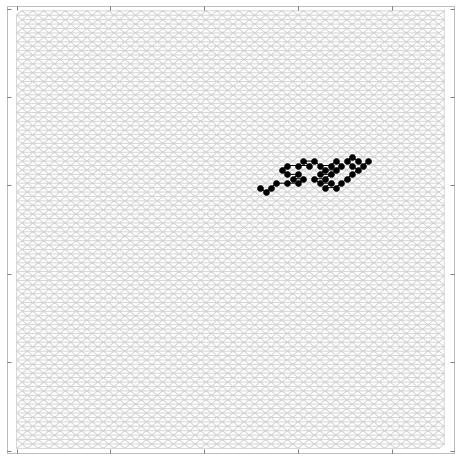

In [23]:
Ly = 40
main = Main(Lx=100, Ly=Ly, size=[Ly])

In [7]:
Ly = 5
main = Main(Lx=10, Ly=Ly, size=[Ly])

隣接する二つの単位要素が同じベクトルである場合(=なす角が0であるベクトルの組)の数を数える。

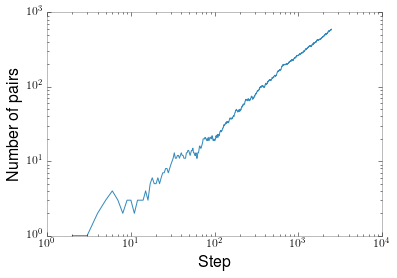

In [6]:
%matplotlib inline
main = Main(Lx=50, Ly=50, size=[random.randint(4, 12)] * 1, plot=False)

fig, ax = plt.subplots()
ax.loglog(range(len(main.pairs)), main.pairs)
ax.set_xlabel("Step")
ax.set_ylabel("Number of pairs")
plt.show()

AttributeError: Main instance has no attribute 'bend1'

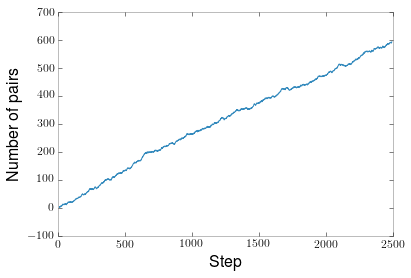

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel("Step")
ax.set_ylabel("Number of pairs")
steps = range(len(main.pairs))
ax.plot(steps, main.pairs, label="straight")
ax.legend(loc="best")
plt.show()


`main.pairs`がべき乗則に従いそう。
フィッティングを行う。

D = 0.893005


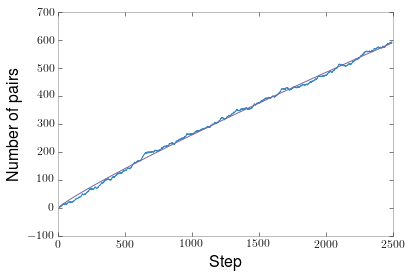

In [9]:
import scipy.optimize as optimize


X, Y = range(len(main.pairs)), main.pairs

def fit_func(parameter0, x, y):
    c1 = parameter0[0]
    c2 = parameter0[1]
    residual = y - c1*(x**c2)
    return residual

_from = 20

parameter0 = [0., 1.]
result = optimize.leastsq(fit_func, parameter0, args=(X[_from:], Y[_from:]))
c1 = result[0][0]
D = result[0][1]
print "D = %f" % D

def fitted(x, c1, D):
    return c1 * (x**D)

fig, ax = plt.subplots()
ax.plot(X, Y)
ax.plot(X[_from:], fitted(X[_from:], c1, D))
ax.set_xlabel("Step")
ax.set_ylabel("Number of pairs")
plt.show()